This notebook is used to generate the ground truth of new images. It creates .h5 files

#Setup

##Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/TFE_crowd_counting/CSRNet-pytorch')

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
from matplotlib import cm as CM
from image import *
                          
%matplotlib inline

Mounted at /content/gdrive


##Paths

In [ ]:
#set the paths for differents datasets

#Shangai dataset to reproduce results from the paper
'''
root = '/content/gdrive/My Drive/TFE crowd counting/ShanghaiTech_Crowd_Counting_Dataset/'
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
#partA
path_sets = [part_A_train,part_A_test]
#partB
#path_sets = [part_B_train,part_B_test]
'''

#Auditorium images
root = '/content/gdrive/My Drive/TFE_crowd_counting/Dataset/Basic datas/'
images_path = os.path.join(root,'images/Test_small')
GT_path = os.path.join(root,'ground_truth/Test_small')
path_sets = [images_path] #All images at the same place
img_format = '.png' #or '.png' or '.jpg'

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.png')):
      if not os.path.exists(img_path.replace('.png', '.h5').replace('images', 'ground_truth')):
        img_paths.append(img_path)
 
print(len(img_paths))

31


#Utils

In [ ]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet

#This function create the density by using adaptive kernels
def gaussian_filter_density(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    pts = list(zip(np.nonzero(gt)[1],np.nonzero(gt)[0]))  
    pts = np.array(pts)
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point 
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    return density

In [ ]:
#Method to generate h5 ground_truth file based on the paths to the images file
#Crowded = False -> Usage of only gaussian // Crowded = True -> Usage of geometric adaptive kernel

def gt_gen(img_paths, crowded = True ,Verbose = False):
  count=1
  for img_path in img_paths:
        mat = io.loadmat(img_path.replace(img_format,'.mat').replace('images','ground_truth').replace('A10','GT_A10'))
        img= plt.imread(img_path)
        k = np.zeros((img.shape[0],img.shape[1]))
        gt = mat["image_info"][0,0][0,0][0]
        for i in range(0,len(gt)):
            if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
                k[int(gt[i][1]),int(gt[i][0])]=1.
        
        #density generation for crowded image
        if crowded:
          k = gaussian_filter_density(k)
        #density generation for non crowded image
        else:
          k = gaussian_filter(k,15)

        with h5py.File(img_path.replace(img_format,'.h5').replace('images','ground_truth'), 'w') as hf:
                hf['density'] = k
        if Verbose:
          print("image "+str(count) + "/" + str(len(img_paths))+ " done")
          count+=1


In [ ]:
print(img_paths[29])

/content/gdrive/My Drive/TFE_crowd_counting/Dataset/Basic datas/images/A10_small/A10_small_31.png


#GT Generation

In [ ]:
gt_gen(img_paths,Verbose = True)

image 1/31 done
image 2/31 done
image 3/31 done
image 4/31 done
image 5/31 done
image 6/31 done
image 7/31 done
image 8/31 done
image 9/31 done
image 10/31 done
image 11/31 done
image 12/31 done
image 13/31 done
image 14/31 done
image 15/31 done
image 16/31 done
image 17/31 done
image 18/31 done
image 19/31 done
image 20/31 done
image 21/31 done
image 22/31 done
image 23/31 done
image 24/31 done
image 25/31 done
image 26/31 done
image 27/31 done
image 28/31 done
image 29/31 done
image 30/31 done
image 31/31 done


In [ ]:
#Clear new_datas folders
for image in img_paths:
  os.remove(image)
  os.remove(image.replace(img_format,'.mat').replace('images','ground_truth').replace('A10_','GT_A10_'))

FileNotFoundError: ignored

#Visualization

/content/gdrive/My Drive/TFE_crowd_counting/Dataset/Basic datas/images/Images VM/A10_113.png


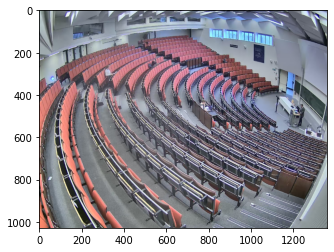

In [ ]:
plt.imshow(Image.open(img_paths[0]))
print(img_paths[2])

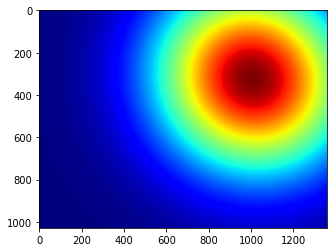

In [ ]:
gt_file = h5py.File(img_paths[2].replace('.png','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
print(np.sum(groundtruth))

1.4661846
